# 📚 Imports
---

In [1]:
import pandas as pd
import numpy as np
import re
from unidecode import unidecode

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import collections

from textblob import TextBlob

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# 📖 Data
---

In [2]:
df = pd.read_csv('data/chat_dataset.csv')
df.head()

,message,sentiment
0,I really enjoyed the movie,positive
1,The food was terrible,negative
2,I'm not sure how I feel about this,neutral
3,The service was excellent,positive
4,I had a bad experience,negative


In [3]:
df['sentiment'].value_counts()

neutral     259
positive    178
negative    147
Name: sentiment, dtype: int64

In [4]:
df.isna().sum()

message      0
sentiment    0
dtype: int64

# 🧹 Text Preprocessing
---

### Cleaning Text

In [5]:
# Variable to replace all characters that are not letters or whitespace
regex = re.compile('[^a-z\s]')
# Convert text to lower case
df['clean_text'] = df['message'].str.lower()
# Removes all characters that are not letters or spaces
df['clean_text'] = df['clean_text'].apply(lambda x: regex.sub('', x))
# Removes all characters between square brackets
df['clean_text'] = df['clean_text'].str.replace('[%s]', '', regex = True)
# Remove the accents
df['clean_text'] = df['clean_text'].apply(lambda x: regex.sub('', unidecode(x)))
# Remove ing
df['clean_text'] = df['clean_text'].str.replace('ing', '', regex = True)
# Remove words with less than 3 characters
df['clean_text'] = df['clean_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))


### Correct the words

In [6]:
# Function to correct the words
def correct_spelling(text):
    blob = TextBlob(text)
    return str(blob.correct())

# Apply the function
df['corrected_text'] = df['clean_text'].apply(correct_spelling)

# Result
df['corrected_text'].head()

0      really enjoyed the movie
1             the food terrible
2    not are how feel about the
3         the service excellent
4            had bad experience
Name: corrected_text, dtype: object

### Removing StopWords

In [530]:
# Tokenization
df['text_without_stopwords'] = df['corrected_text'].apply(word_tokenize)

# Removing stopwords
stop_words = set(stopwords.words('english'))
df['text_without_stopwords'] = df['text_without_stopwords'].apply(lambda x: [word for word in x if word not in stop_words])

# Result
df['text_without_stopwords'].head()

0    [really, enjoyed, movie]
1            [food, terrible]
2                      [feel]
3        [service, excellent]
4           [bad, experience]
Name: text_without_stopwords, dtype: object

### Word Normalization

In [531]:
# Word normalization
stemmer = SnowballStemmer('english')
df['final_text'] = df['text_without_stopwords'].apply(lambda x: [stemmer.stem(word) for word in x])

# Joining the words back into a single text
df['final_text'] = df['final_text'].apply(lambda x: ' '.join(x))

# Result
df['final_text'].head()

0    realli enjoy movi
1         food terribl
2                 feel
3         servic excel
4           bad experi
Name: final_text, dtype: object

# 📊 Visualization
---

### Top 10 most used words

Text(0, 0.5, 'Frequency')

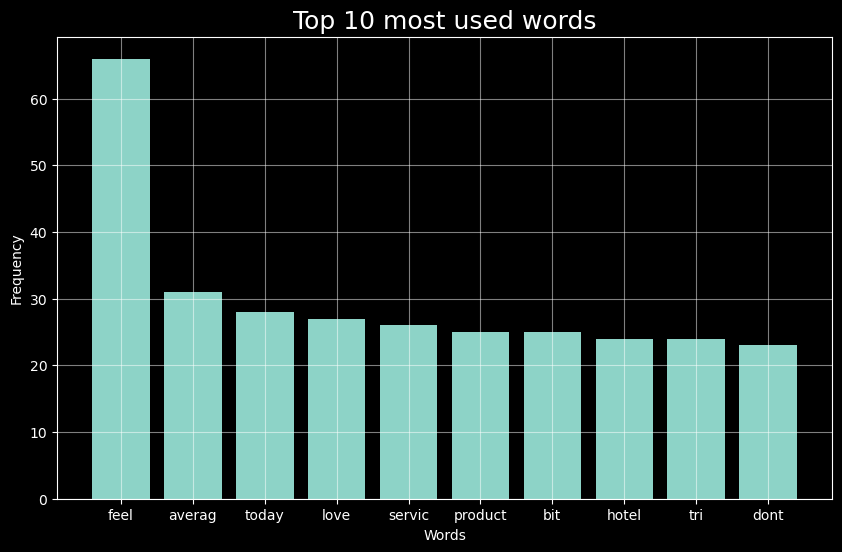

In [532]:
words = []
for text in df['final_text']:
    words.extend(text.split())
word_count = collections.Counter(words)
top_words = dict(word_count.most_common(10))

# Figure Size
plt.figure(figsize = (10, 6))

# Create the Barplot
plt.bar(range(len(top_words)), list(top_words.values()), align = 'center')

# Creating a y axis with words
plt.xticks(range(len(top_words)), list(top_words.keys()))

# Grid Opacity
plt.grid(alpha = 0.5)

# Title
plt.title('Top 10 most used words', fontsize = 18)

# Labels
plt.xlabel('Words')
plt.ylabel('Frequency')

### Words Graph

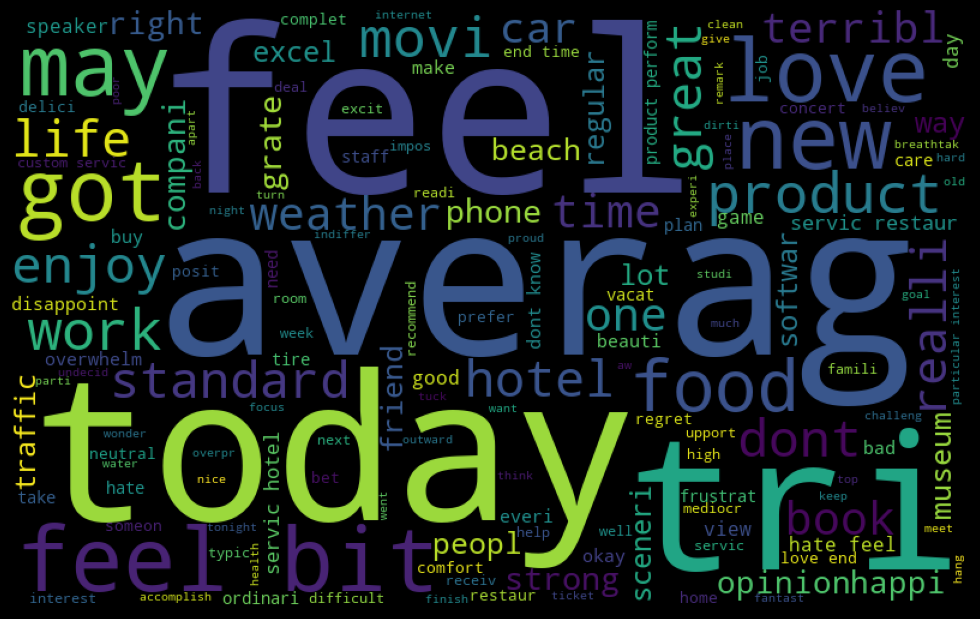

In [533]:
text = ' '.join(caption for caption in df['final_text'])

wordcloud = WordCloud(width = 800, height = 500, background_color = 'black', 
                min_font_size = 10).generate(text)

plt.figure(figsize = (10, 6), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

# 🏋️ Training
---

### Changing sentiment column classes to numbers
neutral == 0 | positive == 1 | negative == 2

In [534]:
df['sentiment'] = df['sentiment'].map({'neutral' : 0, 'positive' : 1, 'negative' : 2})

### Separating Data for Sorting with CountVectorizer

In [535]:
# Split X and Y
x = np.array(df['final_text'])
y = np.array(df['sentiment'])

# Convert text to numerical
cv = CountVectorizer()
X = cv.fit_transform(x)

xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.25, random_state = 0)

### Training

In [536]:
# Models
mnb = MultinomialNB()
bnb = BernoulliNB()

# Training
mnb.fit(xtrain, ytrain)
bnb.fit(xtrain, ytrain)

BernoulliNB()

### Predicts

In [537]:
# Predictions
pred_mnb = mnb.predict(xtest)
pred_bnb = bnb.predict(xtest)

# 📋 Results
---

### MultinomialNB

In [539]:
print(f'Multinomial Accuracy: {accuracy_score(ytest, pred_mnb)}')
print('-' * 55)
print(classification_report(ytest, pred_mnb))

Multinomial Accuracy: 0.8082191780821918
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.92      0.89        64
           1       0.70      0.85      0.77        41
           2       0.89      0.59      0.71        41

    accuracy                           0.81       146
   macro avg       0.81      0.79      0.79       146
weighted avg       0.82      0.81      0.80       146



### Bernoulli Accuracy

In [540]:
print(f'Bernoulli Accuracy: {accuracy_score(ytest, pred_bnb)}')
print('-' * 55)
print(classification_report(ytest, pred_bnb))

Bernoulli Accuracy: 0.7054794520547946
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.66      0.95      0.78        64
           1       0.74      0.71      0.72        41
           2       0.87      0.32      0.46        41

    accuracy                           0.71       146
   macro avg       0.76      0.66      0.66       146
weighted avg       0.74      0.71      0.68       146



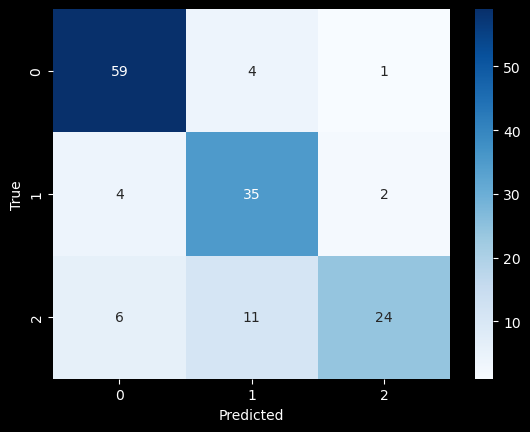

In [552]:
cm = confusion_matrix(ytest, pred_mnb)
sns.heatmap(cm, annot = True, cmap = 'Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# 🏁 Thank you! Feel free to criticize! 🏁